In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages') # make sure it can get virtualenv lib
import age_gender_predictor
from datetime import datetime, timedelta
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from copy import copy
import pandas as pd
import json
import os
from collections import defaultdict

## Loding scikit-learn models

In [2]:
def load_model(file_location):
    model = joblib.load(file_location)
    return model 

#Loding Bipolar Random Forest
bipolar_model = load_model("models/bipolar_forest/bipolar_forest_0")


## Process Data Function
### Age and gender Distribution

In [3]:
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

### Social Feature

In [4]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for method in methods:
        feature_set.update(method(group.getGroup(tail_k)))
    return feature_set


### Polarity Feature

In [5]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

### Emotion Feature

In [6]:
def date_not_in_range(user, date):
    if date >= patient_month_time_dict[user] - timedelta(days=42) \
    and date <= patient_month_time_dict[user] + timedelta(days=14):
        return False
    else:
        return True

    


def getUsersEmotionsDict(users_timeSeries):
#     user -> emotion count
    user_emotion_dict = defaultdict(lambda: {"joy":0,
                                       "sadness": 0,
                                       "fear":0,
                                       "anticipation": 0,
                                       "anger":0,
                                       "trust": 0,
                                       "disgust": 0,
                                       "surprise" : 0
                                      })
    for user in users_timeSeries:
        user_tweets_count = 0
#         date, [tweet_info, tweets_info ...]
        for date, tweets_infos in users_timeSeries[user].iteritems():
            if date_not_in_range(user, datetime.strptime(str(date), "%Y%m%d")): continue
            for tweet_info in tweets_infos:                
    #             content, emotion1, emotion2, ambiguous
                if(tweet_info[3].strip() != 'yes'):
    #         only get the first emotion now
                    user_emotion_dict[user][tweet_info[1]] += 1
                    user_tweets_count += 1
    
        for emotion in user_emotion_dict[user]:
            if user_tweets_count == 0:
                user_emotion_dict[user][emotion] = 0
            else:
                user_emotion_dict[user][emotion] = float(user_emotion_dict[user][emotion]) / user_tweets_count
    return user_emotion_dict

def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [24]:
def getPOLFeature(user_timeSeries_list):
    features = np.zeros((len(user_timeSeries_list),12),dtype=float)
    for i, timeSeries in enumerate(user_timeSeries_list):
        
        tweets_length = float(timeSeries.shape[0])
        tweets_rate = getTweetRate(timeSeries)
        late_tweets_rate = getLateTweetRate(timeSeries)
        mention_rate = getMentionRate(timeSeries)
        unique_mentions = getUniqueMentions(timeSeries)
        frequent_mentions = getFrequentMentions(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        positive_ratio = getPositiveRatio(timeSeries)
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos = getCombosCount(timeSeries) / tweets_length
        positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length


        age = getAge(timeSeries)
        gender = getGender(timeSeries)

        features[i][0] = tweets_rate
        features[i][1] = late_tweets_rate
        features[i][2] = mention_rate
        features[i][3] = unique_mentions
        features[i][4] = frequent_mentions 
        features[i][5] = positive_ratio
        features[i][6] = negative_ratio
        features[i][7] = flips_ratio
        features[i][8] = negative_combos
        features[i][9] = positive_combos
        features[i][10] = age
        features[i][11] = gender
            
    return features

# Predict

In [31]:
def pol_report(timeline):
#     A list of 8-weeks-timeSeries timeline
    timeSeries_list = getTimeSeries(timeline)
    features = getPOLFeature(timeSeries_list)
    
    user_timeline_reports = []
    for i, feature in enumerate(features):
        timeSeries = timeSeries_list[0]
        bipolar_proba = bipolar_model.predict_proba(feature)[0][1]

        report = {}
        report["tweets_length"] = timeSeries_list[i].shape[0]
        report["tweeting_frequency"] = feature[0]
        report["late_tweeting_frequency"] = feature[1]
        report["mentioning_frequency"] = feature[2]
        report["unique_mentioning"] = feature[3]
        report["frequent_mentioning"] = feature[4]
        report["positive_ratio"] = feature[5]
        report["negative_ratio"] = feature[6]
        report["flips_ratio"] = feature[7]
        report["negative_combos"] = feature[8]
        report["positive_combos"] = feature[9]
        report["age"] = features[0][10]
        report["gender"] = "Male" if features[0][11] < 0 else "Female"
        report["bipolar_probability"] = bipolar_proba
        
        user_timeline_reports.append(report)

    return user_timeline_reports


### Load Predict File

In [9]:
def checkFolderFile(folder):
    return os.listdir(folder)

# ## Read BD_user
def loadTweets(folder, filename, tweets_dict):
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            try:
                username, date, datetime, content, sentiment, emotion1, emotion2, ambiguous = line.split('\t')
            except:
                print(line.split('\t'))
            tweets_dict[username][int(date)].append((datetime, content, sentiment, emotion1, emotion2, ambiguous.strip()))
    return tweets_dict

In [10]:
def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=25, time_filter = False):    #Spam and inactive user filter
#     to restrict date in latest 8 weeks
    if time_filter == True:
        temp_group=[]
        for timeSeries in group:
            eight_week_period = timeSeries.index[-1]- timedelta(weeks=8)
            temp_group.append(timeSeries[timeSeries.index > eight_week_period])
        group = temp_group
            
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group

def TweetsFormating(tweets_dict, en_threshold=0.9):
    usersTweets = {}
    true_yes_dict = {'yes':True, 'no':False, 'None': True}
    for user in tweets_dict:       
        userID = user
        for date_ in tweets_dict[user]:              
            for tweet_info in tweets_dict[user][date_]:
                date, content, polarity, emotion1, emotion2, ambiguous = tweet_info
   
                date = datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S")
                text = content
                
                if userID not in usersTweets:
                    usersTweets[userID] = {}
                if date not in usersTweets[userID]:
                    usersTweets[userID][date] = {}

                usersTweets[userID][date]['text'] = text
                usersTweets[userID][date]['polarity'] =  int(polarity.strip())
                
                
                usersTweets[userID][date]['emotion'] =  emotion1
                usersTweets[userID][date]['emotion_2'] =  emotion2
                usersTweets[userID][date]['ambiguous'] =  true_yes_dict[ambiguous]

    return usersTweets
    

In [11]:
user_folder = 'patient emo_senti/'
# {username:{int(date):{[(datetime,content,sentiment,emotion1,emotion2,ambiguous),...]}}}
bd_tweets_dict = defaultdict(lambda: defaultdict(lambda:[]))
for user in checkFolderFile(user_folder):
    bd_tweets_dict = loadTweets(user_folder, user, bd_tweets_dict)

In [12]:
len(bd_tweets_dict)

184

In [13]:
bd_tweets = TweetsFormating(bd_tweets_dict)

In [14]:
bd_timeSeries = timeSeriesTransform(bd_tweets)
bd_clean = userFilter(bd_timeSeries, spam_threshold=0.8, tweets_threshold=5)

### 8 Week Slide Windows

In [15]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [47]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

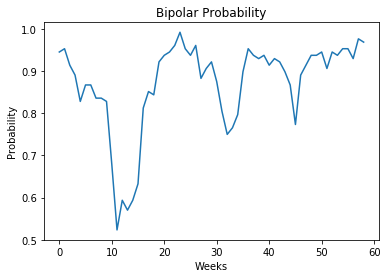

In [46]:
result = pol_report(bd_clean[1])
y = [window_info['bipolar_probability'] for window_info in result]
plt.plot(y)
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Bipolar Probability")
plt.legend(loc="lower right")

plt.show()

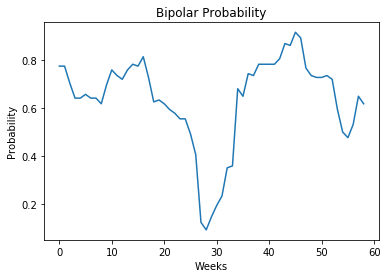

In [50]:
result = pol_report(bd_clean[4])
y = [window_info['bipolar_probability'] for window_info in result]
plt.plot(y)
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Bipolar Probability")
plt.legend(loc="lower right")

plt.show()